# Why Model spits input 

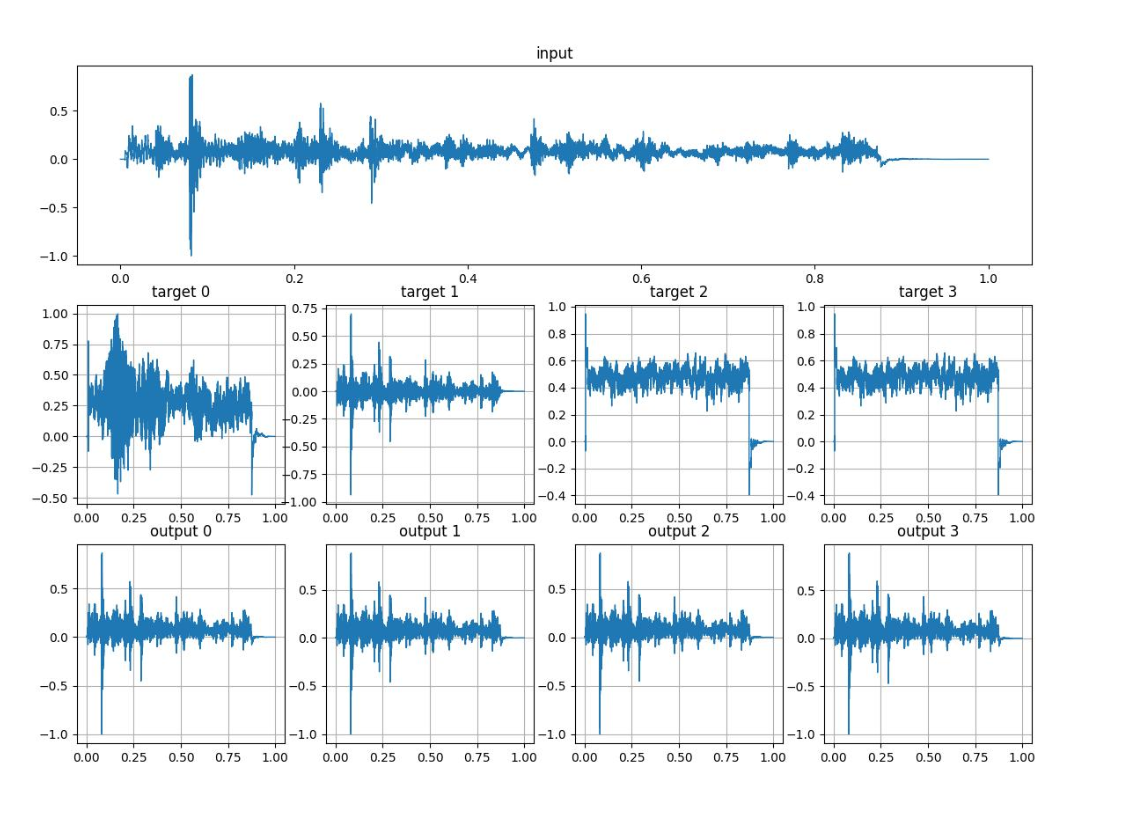

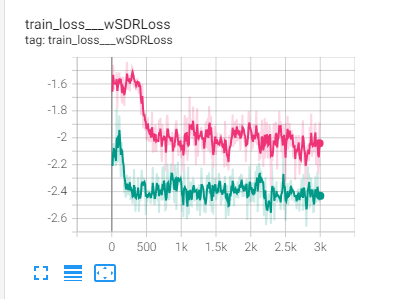

## Loss : Input as output

In [1]:
import torch
import numpy as np
import librosa

/home/kbh/.conda/envs/dnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
def mSDRLoss(output,target, eps=1e-7):
    # Modified SDR loss, <x, x`> / (||x|| * ||x`||) : L2 Norm.
    # Original SDR Loss: <x, x`>**2 / <x`, x`> (== ||x`||**2)
    #  > Maximize Correlation while producing minimum energy output.
    #xx = torch.dot(output,output)
    #xy = torch.dot(output,target)

    #return xx/(xy**2)
    correlation = torch.sum(target * output, dim=1)
    energies = torch.norm(target, p=2, dim=1) * torch.norm(output, p=2, dim=1)

    return torch.mean(-(correlation / (energies + eps)))

def wSDRLoss(output,noisy,target,alpha=0.01,inSTFT=True,eps=2e-7):
        noise = noisy - target
        noise_est = noisy - output

        wSDR = alpha * mSDRLoss(output,target,eps=eps) + (1-alpha)*mSDRLoss(noise_est,noise,eps=eps)
        return wSDR
    
def SDRLoss(output,target,eps=2e-7):
    xy = torch.diag(output @ target.t())
    yy = torch.diag(target @ target.t())
    xx = torch.diag(output @ output.t())

    SDR = xy**2/ (yy*xx - xy**2 )
    return torch.mean(SDR)
def logSDRLoss(output,target,eps=2e-7):
    xy = torch.diag(output @ target.t())
    yy = torch.diag(target @ target.t())
    xx = torch.diag(output @ output.t())

    SDR = xy**2/ (yy*xx - xy**2 )
    return torch.mean(-10*torch.log10(SDR+1))

def iSDRLoss(output,target,eps=2e-7):
    sdr = SDRLoss(output,target,eps)
    return 1/sdr

In [27]:
mixture, _ = librosa.load("input.wav",sr=16000)
target = []
output = []
for i in range(4) : 
    target.append(librosa.load("target_{}.wav".format(i),sr=16000)[0])
    output.append(librosa.load("39_{}.wav".format(i),sr=16000)[0])

mixture=torch.from_numpy(np.expand_dims(mixture,0))
for i in range(4) : 
    target[i]=torch.from_numpy(np.expand_dims(target[i],0))
    output[i]=torch.from_numpy(np.expand_dims(output[i],0))
    
for i in range(4) :
    print(target[i].shape)
    print(output[i].shape)

torch.Size([1, 16000])
torch.Size([1, 16000])
torch.Size([1, 16000])
torch.Size([1, 16000])
torch.Size([1, 16000])
torch.Size([1, 16000])
torch.Size([1, 16000])
torch.Size([1, 16000])


In [44]:
print("alpha : 0.1")
alpha = 0.5
for i in range(4) : 
    print("== {} ==".format(i))
    print("iSDRLoss ideal     : {}".format(wSDRLoss(target[i],mixture,target[i],alpha)))
    print("iSDRLoss output    : {}".format(wSDRLoss(output[i],mixture,target[i],alpha)))
    print("iSDRLoss mixture    : {}".format(wSDRLoss(mixture,mixture,target[i],alpha)))
    #print("iSDRLoss ideal     : {}".format(iSDRLoss(target[i],target[i])))
    #print("iSDRLoss target    : {}".format(iSDRLoss(output[i],target[i])))
    #print("iSDRLoss mixture   : {}".format(iSDRLoss(mixture,target[i])))
    print("logSDRLoss ideal   : {}".format(logSDRLoss(target[i],target[i])))
    print("logSDRLoss target  : {}".format(logSDRLoss(output[i],target[i])))
    print("logSDRLoss mixture : {}".format(logSDRLoss(mixture,target[i])))
    #torch.stft(x, self.n_fft, hop_length=None, win_length=None, window=self.window, center=True, normalized=False, onesided=None, length=None, return_complex=False)
    
    #print(wSDRLoss(output[i],mixture,target[i],alpha=0.9))
    #print(wSDRLoss(output[i],mixture,mixture,alpha=0.9))
          

alpha : 0.1
== 0 ==
iSDRLoss ideal     : -1.0000073909759521
iSDRLoss output    : -0.9366524815559387
iSDRLoss mixture    : -0.35713207721710205
logSDRLoss ideal   : tensor([-inf])
logSDRLoss target  : tensor([-10.5119])
logSDRLoss mixture : tensor([-3.0995])
== 1 ==
iSDRLoss ideal     : -1.0000078678131104
iSDRLoss output    : -0.8716387748718262
iSDRLoss mixture    : -0.2632581889629364
logSDRLoss ideal   : tensor([-inf])
logSDRLoss target  : tensor([-6.1615])
logSDRLoss mixture : tensor([-1.4099])
== 2 ==
iSDRLoss ideal     : -1.0000054836273193
iSDRLoss output    : -0.8521064519882202
iSDRLoss mixture    : -0.12838806211948395
logSDRLoss ideal   : tensor([-inf])
logSDRLoss target  : tensor([-4.5911])
logSDRLoss mixture : tensor([-0.2962])
== 3 ==
iSDRLoss ideal     : -1.0000078678131104
iSDRLoss output    : -0.9267439246177673
iSDRLoss mixture    : -0.18650291860103607
logSDRLoss ideal   : tensor([-inf])
logSDRLoss target  : tensor([-8.0773])
logSDRLoss mixture : tensor([-0.6506])
